In [1]:
from dike_model_function import DikeNetwork
from problem_formulation import get_model_for_problem_formulation
from ema_workbench.analysis import prim
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from ema_workbench import MultiprocessingEvaluator, ema_logging
import pickle

In [2]:
model, _ = get_model_for_problem_formulation(2)

In [3]:
from ema_workbench import Samplers

ema_logging.log_to_stderr(ema_logging.INFO)

n_scenarios = 1000 
n_policies = 250 
# In assignment 5 at first 1000 is used, but with only 10 policies. 
# We use 500 scenarios with 50 policies for PRIM. 
# For the dimensional stacking we use more scenarios to fill in the white blanks in the stacking outcomes.
# We use 1000 scenarios and 250 policies for Dimensional Stacking

use_pickle1 = True
#This is used to save time. Otherwise we need to re-run the MultiprocessingEvaluator every time.
# It is set on False when we re-runned the model for Dimensional Stacking.

if use_pickle1:
    with open('data/PRIM_results1.pickle','rb') as filehandler:
        results = pickle.load(filehandler)
else:
    with MultiprocessingEvaluator(model,n_processes=10) as evaluator:
        results = evaluator.perform_experiments(n_scenarios, n_policies, uncertainty_sampling=Samplers.LHS)
    
    with open('data/PRIM_results1.pickle',"wb") as filehandler:
        pickle.dump(results,filehandler)

[MainProcess/INFO] pool started with 10 workers
[MainProcess/INFO] performing 1000 scenarios * 250 policies * 1 model(s) = 250000 experiments
100%|████████████████████████████████| 250000/250000 [5:21:57<00:00, 12.94it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [4]:
experiments, outcomes = results

In [5]:
cleaned_experiments = experiments.drop(['policy','scenario','model'],axis=1)
# we drop 3 columns here

In [6]:
outcomesdataframe = pd.DataFrame.from_dict(outcomes)

In [7]:
outcomesdataframe.head()

,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths
0,9.086059e+08,7.176909e+08,1.561600e+09,8469.744300,0.083543
1,0.000000e+00,7.176909e+08,1.561600e+09,0.000000,0.000000
2,0.000000e+00,7.176909e+08,1.561600e+09,0.000000,0.000000
3,1.839879e+06,7.176909e+08,1.561600e+09,81.920029,0.000098
4,0.000000e+00,7.176909e+08,1.561600e+09,0.000000,0.000000


In [8]:
import numpy as np

data = (outcomes['Expected Number of Deaths'] <= 0.001) # Set a maximum value on Expected number of deaths
y = data
# First I used this: y = data < np.percentile(data,50) #median, everything under the 50%

In [9]:
#threshold (float) – the density threshold that a box has to meet
#Not sure which tresholds we need to use?
prim_alg = prim.Prim(cleaned_experiments,y, threshold=0.8, peel_alpha=0.05) #Default of PRIM sets mass_min and peel_alpha also on 0.05
box1 = prim_alg.find_box()

[MainProcess/INFO] 250000 points remaining, containing 107520 cases of interest
[MainProcess/INFO] mean: 0.9987756351392715, mass: 0.052272, coverage: 0.12139136904761905, density: 0.9987756351392715 restricted_dimensions: 13


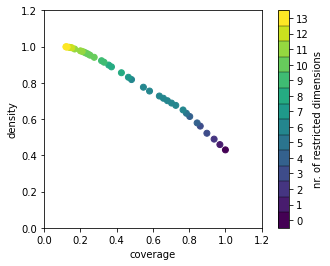

In [10]:
box1.show_tradeoff()
plt.show()

coverage    0.766267
density     0.650330
id          8.000000
mass        0.506752
mean        0.650330
res_dim     6.000000
Name: 8, dtype: float64

                       box 8                                            
                         min        max                        qp values
A.2_DikeIncrease 0  1.500000  10.000000                      [0.0, -1.0]
A.5_DikeIncrease 0  1.500000  10.000000                      [0.0, -1.0]
A.3_DikeIncrease 0  0.500000  10.000000  [2.5472153814361435e-234, -1.0]
A.3_pfail           0.049957   0.999185    [8.994902090166152e-49, -1.0]
A.5_pfail           0.052050   0.999410   [1.9424738694029853e-43, -1.0]
A.2_pfail           0.049927   0.999448    [3.195161221108217e-42, -1.0]



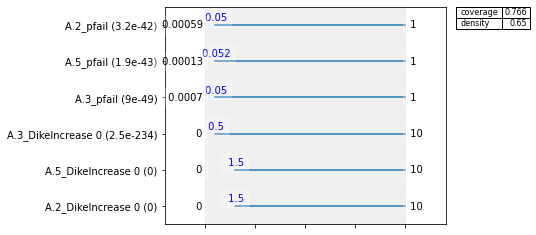

In [11]:
box1.inspect(8)  #Looking at the outcome above, the 8th dot seems to meet the best combination of coverage & density
box1.inspect(8, style='graph')
plt.show()

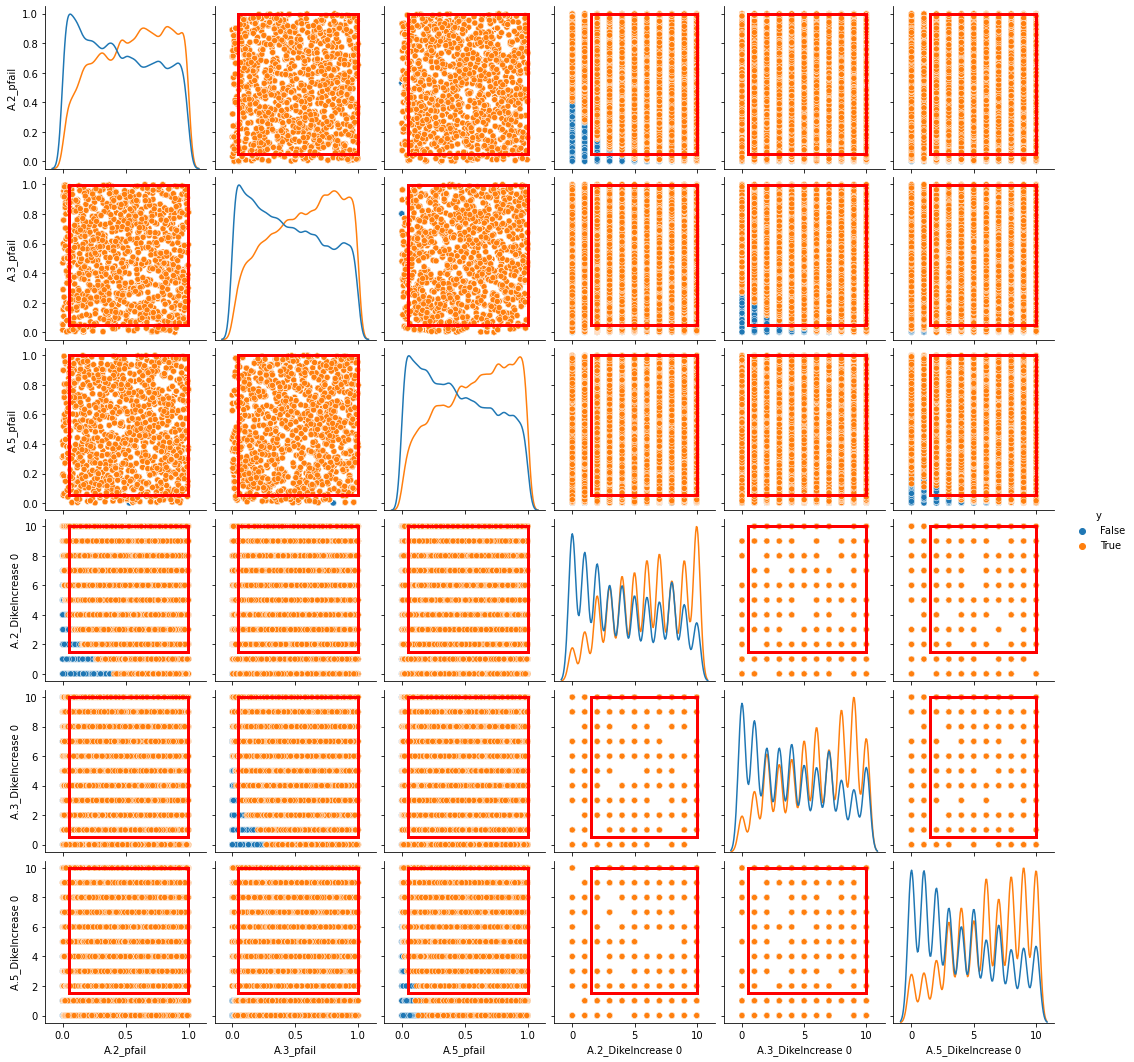

In [12]:
box1.show_pairs_scatter(8)
plt.show()

In [13]:
from ema_workbench.analysis import dimensional_stacking

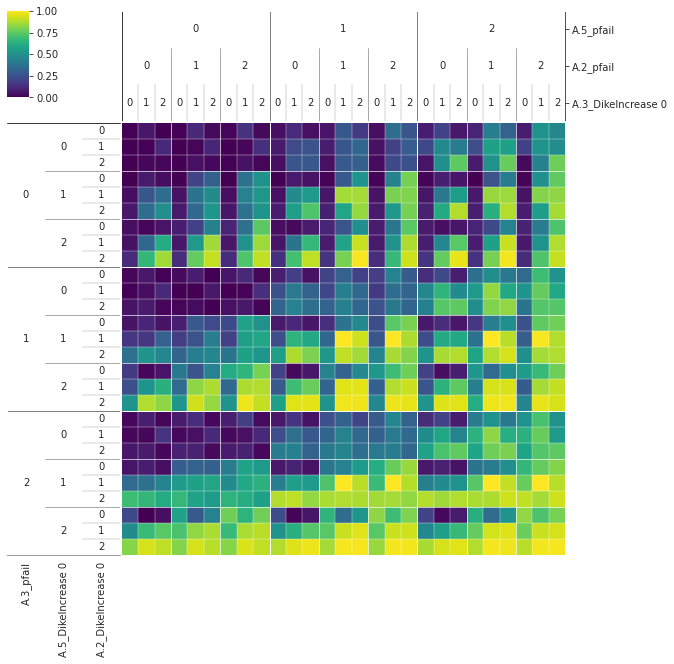

In [14]:
dimensional_stacking.create_pivot_plot(cleaned_experiments, y)
plt.show()